## Data Understanding
- The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 
- The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

- Data Dictionary:
    - Input variables:
    ### bank client data:
    - 1 - age (numeric)
    - 2 - job : type of job (categorical: 'admin.','blue collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    - 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    - 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    - 5 - default: has credit in default? (categorical: 'no','yes','unknown')
    - 6 - balance
    - 7 - housing: has housing loan? (categorical: 'no','yes','unknown')
    - 8 - loan: has personal loan? (categorical: 'no','yes','unknown')
    ### related with the last contact of the current campaign:
    - 9 - contact: contact communication type (categorical: 'cellular','telephone') 
    - 10 - day: last contact day of the week (int: 1-7)
    - 11 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    - 12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
    ### other attributes:
    - 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    - 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    - 15 - previous: number of contacts performed before this campaign and for this client (numeric)
    - 16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

    ### Output variable (desired target):
    - 17 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### View as a Pandas Dataframe

In [2]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


### Is the target class balanced?

In [3]:
df.groupby('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


- Yes, almost perfectly balanced. Dataset downloaded from Kaggle shows a nearly balanced set.

In [7]:
#similar to printSchema, see datatypes:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

### Show Summary Stats for numeric features

In [11]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


### Scatter Matrix - Looking for obvious relationships

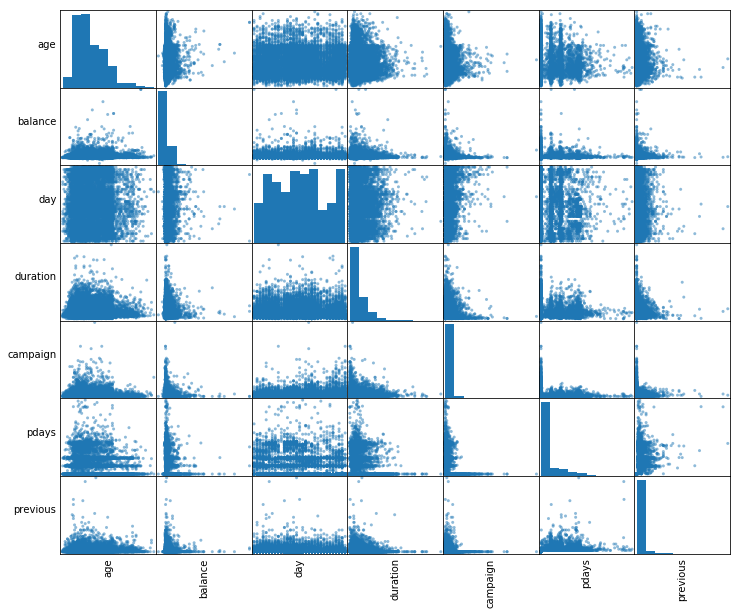

In [15]:
numeric_data = df.select(numeric_features).toPandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(12, 10));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

- There are no obvious highly correlated variable pairs
- Let's remove day and month, but keep the rest of the variables
- 14 input/predictor variables, 1 response/target variable

In [17]:
#remove day & month
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Prep Data for Machine Learning: creating a "stages" object to pass into a PySpark ML Pipeline that achieves 3 unique steps:
    1. Category Indexing
    2. One-Hot Encoding
    3. VectorAssembler - a feature transformer that merges multiple columns into a vector column.

In [20]:
# 1. Category Indexing &2. One-Hot Encoding
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []


for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

In [21]:
# 3. VectorAssembler
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

1. indexes each categorical column using the StringIndexer, 
2. then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. 
3. We use the StringIndexer again to encode our labels to label indices.
4. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

In [22]:
stages

[StringIndexer_229fdd7dfe0e,
 OneHotEncoderEstimator_81683af8986a,
 StringIndexer_0c7bc5a397e0,
 OneHotEncoderEstimator_da5734bd7b3d,
 StringIndexer_ac8aa09388d5,
 OneHotEncoderEstimator_084134171efe,
 StringIndexer_a458bec73d9a,
 OneHotEncoderEstimator_a026d5cdd6a9,
 StringIndexer_75df36ac4ad7,
 OneHotEncoderEstimator_5a67a71d41cb,
 StringIndexer_b08035ef5b4f,
 OneHotEncoderEstimator_1db8b02d4343,
 StringIndexer_8c285327c29e,
 OneHotEncoderEstimator_6e7226eddfab,
 StringIndexer_9c10799ab2eb,
 OneHotEncoderEstimator_290d2194cc5e,
 StringIndexer_56761a24a897,
 VectorAssembler_5611ba1d37e3]

- Binary Classification Labels:
    - 1 = Yes, client has subscribed to a term deposit
    - 0 = No, client did not subscribe to a term deposit

### Create Pipeline

In [23]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [29]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [30]:
# we now have 'features' & 'label' columns

#let's train-test-split usng randomSplit
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7764
Test Dataset Count: 3398


# Modeling

## 1. Logistic Regression

In [31]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [36]:
lrModel.coefficients

DenseVector([-0.2432, -0.3245, -0.0779, 0.1435, -0.3256, 0.6733, -0.448, 0.7662, -0.0946, -0.4697, -0.3079, -0.1946, -0.0231, -0.204, 0.1216, -0.4232, -1.0219, 0.7531, 0.5557, 0.1185, -1.0258, -0.7955, -0.3697, 2.0081, -0.0092, 0.0, 0.005, -0.1367, 0.0001, 0.0006])

##### Beta Coefficient Graph

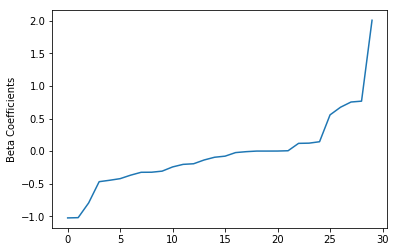

In [33]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

##### ROC Curve

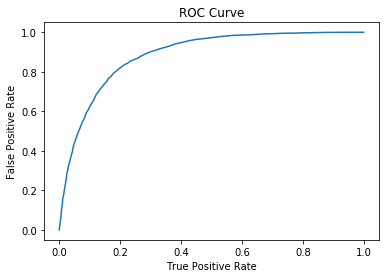

Training set ROC-AUC: 0.8849092421146739


In [35]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set ROC-AUC: ' + str(trainingSummary.areaUnderROC))

##### Precision Recall Graph

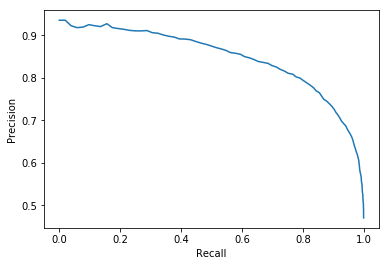

In [45]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### F-Measure by Threshold

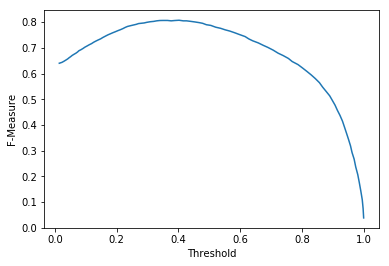

In [47]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

### Make Predictions on Test set

In [52]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(30)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[1.19871810716723...|       0.0|[0.76829666339830...|
| 40|management|  0.0|[2.20534940465796...|       0.0|[0.90072886169926...|
| 53|management|  0.0|[1.02590348276690...|       0.0|[0.73612093009497...|
| 32|management|  0.0|[1.25795481657702...|       0.0|[0.77867383994058...|
| 54|management|  0.0|[1.33232096924268...|       0.0|[0.79122429116078...|
| 40|management|  0.0|[1.57095096412779...|       0.0|[0.82791913346617...|
| 56|management|  0.0|[3.06095963426752...|       0.0|[0.95525333386804...|
| 50|management|  0.0|[-0.8102603273804...|       1.0|[0.30783502428597...|
| 47|management|  0.0|[0.67024288891379...|       0.0|[0.66155754396054...|
| 44|management|  0.0|[1.29756265761715...|       0.0|[0.78542449653716...|
| 40|managem

In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8858324614449619


### Tuning Model Parameters with ParaGridBuilder & Cross Validator

In [55]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8847737068068359


## 2. Decision Tree
    - easy to interpret
    - can handle categorical features
    - can handle multiclass classification
    - feature scaling not necessary
    - can capture non-linearities and feature interactions

In [56]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 37|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 40|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 53|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 32|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 54|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 40|management|  0.0|  [373.0,30.0]|       0.0|[0.92555831265508...|
| 56|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 50|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 47|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 44|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [57]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7910083562522027


- Decision Tree Classifier is little bit less effective than the Logistic Regression above in this particular problem

## 3. Random Forest Classifier

In [59]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[13.7785100822725...|       0.0|[0.68892550411362...|
| 40|management|  0.0|[14.4466362883101...|       0.0|[0.72233181441550...|
| 53|management|  0.0|[12.3210201890791...|       0.0|[0.61605100945395...|
| 32|management|  0.0|[14.2744341383481...|       0.0|[0.71372170691740...|
| 54|management|  0.0|[14.0994135667275...|       0.0|[0.70497067833637...|
| 40|management|  0.0|[13.9329356599365...|       0.0|[0.69664678299682...|
| 56|management|  0.0|[16.7917048155177...|       0.0|[0.83958524077588...|
| 50|management|  0.0|[6.09465777201984...|       1.0|[0.30473288860099...|
| 47|management|  0.0|[9.95869388692553...|       1.0|[0.49793469434627...|
| 44|management|  0.0|[10.2388867442921...|       0.0|[0.51194433721460...|
+---+-------

In [60]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8850323246255517


##### Random Forest Parameter explanations

In [61]:
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

## 4. Gradient-boosted Tree Classifier

In [62]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[0.57808138910181...|       0.0|[0.76063477260811...|
| 40|management|  0.0|[1.37467582901950...|       0.0|[0.93987672346171...|
| 53|management|  0.0|[-0.0012929624008...|       1.0|[0.49935351915983...|
| 32|management|  0.0|[0.61900313605401...|       0.0|[0.77521678642033...|
| 54|management|  0.0|[0.98157815641818...|       0.0|[0.87687413211579...|
| 40|management|  0.0|[0.96138354833170...|       0.0|[0.87244668327834...|
| 56|management|  0.0|[1.39120025731353...|       0.0|[0.94171733839668...|
| 50|management|  0.0|[-0.6141629093446...|       1.0|[0.22647458093662...|
| 47|management|  0.0|[-0.0439971283470...|       1.0|[0.47801561939801...|
| 44|management|  0.0|[0.26452511568224...|       0.0|[0.62926156628314...|
+---+-------

In [63]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8940728473145346


- Gradient-boosted Tree achieved the best result at ROC-AUC Score of 0.89,
- Let's try tuning this model with the ParamGridBuilder and the CrossValidator. 
- we can use explainParams() to print a list of all params and their definitions to understand what params available for tuning.

#### Tuning Gradient Boosted Tree Model with ParamGridBuilder and CrossValidator

In [64]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [66]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8981050997838095
